# I) Least square method

In [1]:
from ngsolve import *
from ngsolve.webgui import Draw

______
# 1) Continuous function
## a) Reference function

We consider the following analytical function supported on a unit square :
$$ u_0 : \left \{ \begin{array}{rcl}
\Omega = [0,1]^2 & \rightarrow & \mathbb R \\
(x_1 , x_2) &\mapsto & (x_1-0.5)^2 + (x_2-0.5)^2
\end{array} \right.$$

In [2]:
from utils.myGeometries import square
Omega = square(maxh=0.2)          # generates the domain and its disretization
x1 = x; x2 = y;                   # to keep the same notation than in the lecture notes
u0 = (x1-0.5)**2 + (x2-0.5)**2    # define the analytic function
Draw(u0, Omega, settings = { "Objects" : { "Wireframe" : False }, "deformation" :  1})

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fals…

BaseWebGuiScene

_____
## b) Discretization
The domain is discretized in conforming triangular elements (no overlap, no nodes within edges).

In [3]:
Draw(Omega)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

BaseWebGuiScene

____
## c) Function spaces

### i) $L^2(\Omega)$ (element DoFs, discontinuous)

$$ L^2(\Omega) = \left \{ u : \Omega \rightarrow \mathbb R, \int_\Omega |u|^2 \leq \infty \right \} $$

Discretized version $L^2(\Omega)$ corresponds to the space of discontinuous functions, defined element-wise.

In [4]:
fesL2 = L2(Omega, order = 0)                     # define the discretized function space
u_L2 = GridFunction(fesL2)                        # define a discretized function
u_L2.vec.data[50] = 1                             # set a DoF to 1
Draw(u_L2, settings = {"deformation" :  0.5})     # vizualize the function

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'deformation': 0.5}, 'ngsolve…

BaseWebGuiScene

### ii) $H^1(\Omega)$ (nodal DoF, continuous)

$$ H^1(\Omega) = \left \{ u \in L^2(\Omega), \nabla u \in L^2(\Omega) \right \} $$ 

Discretization of $H^1(\Omega)$ corresponds to the space of continuous functions, defined node-wise.

In [5]:
fesH1 = H1(Omega, order = 1)                    # define the discretized function space
u_H1 = GridFunction(fesH1)                        # define a discretized function
u_H1.vec.data[35] = 1                             # set a DoF to 1
Draw(u_H1, settings = {"deformation" :  0.5})     # vizualize the function

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'deformation': 0.5}, 'ngsolve…

BaseWebGuiScene

## d) Least square formulation
We look for a function $u\in H$ (with $H=L^2(\Omega)$ or $H^1(\Omega)$ setting the regularity level we want), minimizing the integral of the square error with the reference :
$$ u^* = \arg \min_{u\in H} J(u) = \frac{1}{2}\int_\Omega (u-u_0)^2 $$

In [6]:
def J(u):
    """ integral of the square error """
    return Integrate( (u-u0)**2  , u.space.mesh) / 2

### i) Directional derivative
Given any function $v\in H$ , the directionnal derivative evaluates the first order for a small step in the direction of $v$
$$J'(u; v) =  \lim_{t\rightarrow 0} \frac{J(u+tv) - J(u)}{t} $$

**Exercise**  : find the expression of $J'(u;v)$

### ii) Descent direction

For any $\alpha >0$ we have always 

$$ J'(u; -\alpha (u-u_0) ) = -\alpha \int_\Omega (u-u_0)^2 \leq 0 $$

So $-(u-u_0)$ is a descent direction for $\alpha$ small enough.

In [7]:
def descent_direction(u):
    return -(u-u0)

### iii) Gradient descent

Having a descent direction means we can decrease $J$ by adding $\alpha (u_0-u)$ iteratively to the current trial function $u$ (or to its dofs, after discretization).

#### $H = L^2(\Omega)$

In [8]:
uNew = GridFunction(u_L2.space)
alpha = 0.1
Jlist_L2 = [J(u_L2)]
for i in range(100):
    uNew.Set(u_L2 + alpha * descent_direction(u_L2) )
    u_L2.Set(uNew)
    Jlist_L2.append(J(u_L2))
    # step size adaptation
    if Jlist_L2[-1] < Jlist_L2[-2]:
        alpha *= 1.2
    else:
        alpha /=2

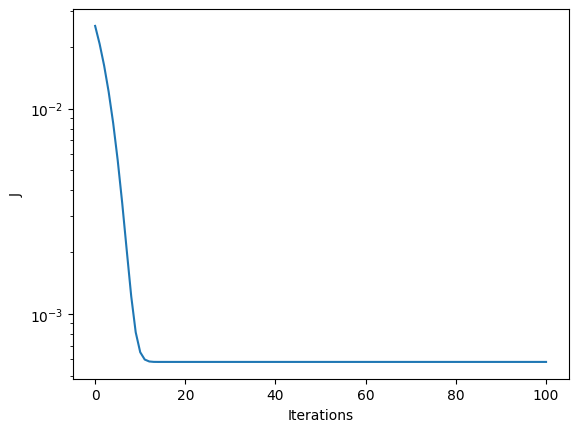

In [9]:
import matplotlib.pyplot as plt
plt.semilogy(Jlist_L2); plt.xlabel("Iterations"); plt.ylabel("J"); plt.show()

**Question** : The final error value is not zero! **Why?**

In [10]:
Draw(u_L2, settings = {"deformation" :  0.5})   # Draw the interpolated function

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'deformation': 0.5}, 'ngsolve…

BaseWebGuiScene

#### $H = H^1(\Omega)$

In [11]:
uNew = GridFunction(u_H1.space)
alpha = 0.1
Jlist_H1 = [J(u_H1)]
for i in range(100):
    uNew.Set(u_H1 + alpha * descent_direction(u_H1) )
    u_H1.Set(uNew)
    Jlist_H1.append(J(u_H1))
    # step size adaptation
    if Jlist_H1[-1] < Jlist_H1[-2]:
        alpha *= 1.2
    else:
        alpha /=2

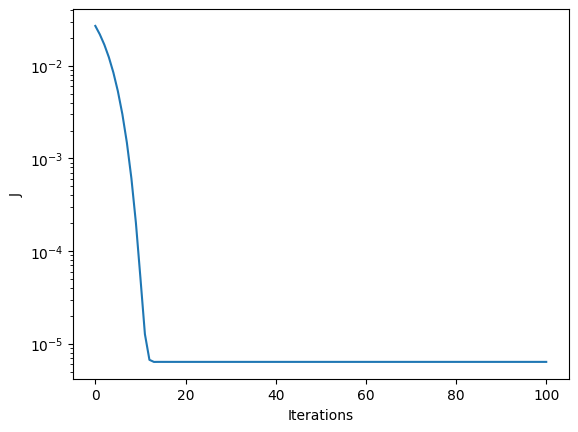

In [12]:
plt.semilogy(Jlist_H1); plt.xlabel("Iterations"); plt.ylabel("J"); plt.show()

The final error is lower! 
- If $u_0$ is regular, then the interpolation should also be regular.

In [13]:
Draw(u_H1, settings = {"deformation" :  0.5})    # Draw the interpolated function

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'deformation': 0.5}, 'ngsolve…

BaseWebGuiScene

______
## Exercise 1) 

The **size** of the mesh elements can be changed using the `maxh` parameter :

In [14]:
maxh = 0.1  # to change (can be done in the code direcly above)
Omega = Mesh(unit_square.GenerateMesh(maxh=maxh))
Draw(Omega)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

BaseWebGuiScene

**Experiment** : Draw a logscale plot of the final error $J_{end}$ with respect to $h$ for $u\in H^1(\Omega)$ and $u\in L^2(\Omega)$. What is the convergence rate ($1/\sqrt{h}$, $1/h$, $1/h^2$ ...) ?

**Analysis** : 
- Explain why having a finer mesh decreases the error.
- Are the convergence rate the same for the continuous and discontinuous interpolations? Explain. 

______
## Exercise 2) 

The interpolation function's **order** of the interpolation function can be changed using the `order` argument.

In NGSolve, hierarchical enrichment of the interpolation are used, meaning some higher degree functions are added to the lower degree ones to enable exact interpolation of any polynomial of degree `order`.

In [15]:
myOrder = 2
fesH1 = H1(Omega, order = myOrder)              # define the discretized function space
u_H1 = GridFunction(fesH1)                        # define a discretized function
u_H1.vec.data[30] = 1                             # set a nodal DoF to 1
u_H1.vec.data[90] = 1                             # set an edge bubble DoF to 1
Draw(u_H1, settings = {"deformation" :  0.5})     # vizualize the function

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'deformation': 0.5}, 'ngsolve…

BaseWebGuiScene

**Experimentation 1** : Draw a logscale plot of the final error $J_{end}$ with respect to $h$ for and $u\in L^2(\Omega)$, for $p=0,1,2$. What are the convergence rates ?

**Analysis** : 
- Comment the $p=2$ case. What would happen for the $p=3$ case?

____________
# 2) Discontinuous function

## a) Reference function

We consider the following function supported on a unit square :
$$ u_0 : \left \{ \begin{array}{rcl}
\Omega = [0,1]^2 & \rightarrow & \mathbb R \\
(x,y) &\mapsto & \mathbb{1}_{[0.4,0.6]^2}
\end{array} \right.$$

In [16]:
from netgen.geom2d import CSG2d, Rectangle
maxh = 0.1
geo = CSG2d()

# define some primitives
box = Rectangle( pmin=(0,0), pmax=(1,1), mat="out")
rect = Rectangle( pmin=(0.3,0.3), pmax=(0.7,0.7), mat="in")

geo.Add(box-rect)
geo.Add(rect)

Omega2 = Mesh(geo.GenerateMesh(maxh=maxh))

u0 = Omega2.MaterialCF({"in" : 1})
Draw(u0, Omega2,  settings = {"deformation" :  0.5})

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'deformation': 0.5}, 'ngsolve…

BaseWebGuiScene

## b) Interpolation with continuous function

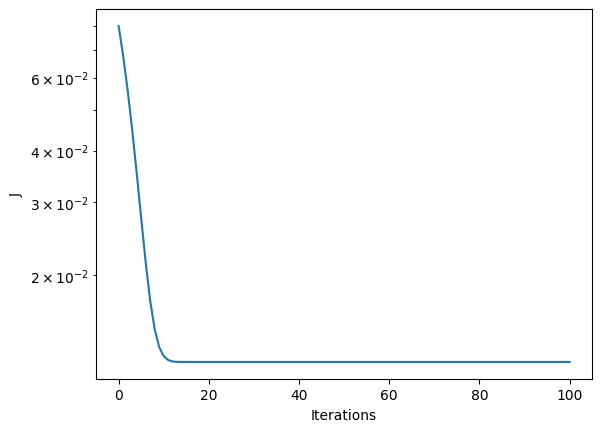

In [18]:
fesH1 = H1(Omega2, order = 1)                    # define the discretized function space
u_H1 = GridFunction(fesH1)                        # define a discretized function

uNew = GridFunction(u_H1.space)
alpha = 0.1
Jlist_H1 = [J(u_H1)]
for i in range(100):
    uNew.Set(u_H1 + alpha * descent_direction(u_H1) )
    u_H1.Set(uNew)
    Jlist_H1.append(J(u_H1))
    if Jlist_H1[-1] < Jlist_H1[-2]:
        alpha *= 1.2
    else:
        alpha /=2
# Plot the convergence
plt.semilogy(Jlist_H1); plt.xlabel("Iterations"); plt.ylabel("J"); plt.show()

In [19]:
Draw(u_H1,  settings = {"deformation" :  0.5})

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'deformation': 0.5}, 'ngsolve…

BaseWebGuiScene

The result is not satisfying : the interpolation has too much regularity! The discontinuity cannot be captured.

## b) Interpolation with discontinuous function

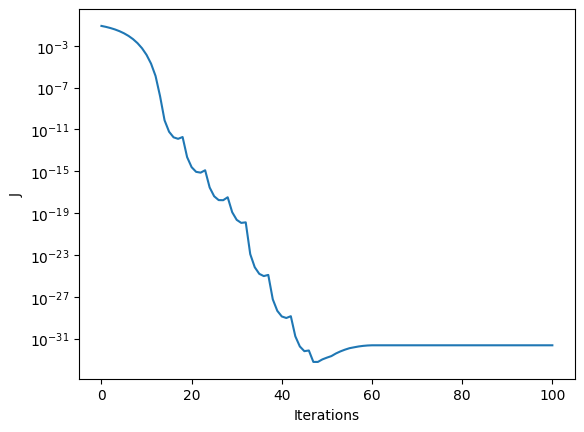

In [21]:
fesL2 = L2(Omega2, order = 0)                    # define the discretized function space
u_L2 = GridFunction(fesL2)                        # define a discretized function
uNew = GridFunction(u_L2.space)
alpha = 0.1
Jlist_L2 = [J(u_L2)]
for i in range(100):
    uNew.Set(u_L2 + alpha * descent_direction(u_L2) )
    u_L2.Set(uNew)
    Jlist_L2.append(J(u_L2))
    if Jlist_L2[-1] < Jlist_L2[-2]:
        alpha *= 1.2
    else:
        alpha /=2
# Plot the convergence
plt.semilogy(Jlist_L2); plt.xlabel("Iterations"); plt.ylabel("J"); plt.show()

In [22]:
Draw(u_L2,  settings = {"deformation" :  0.5})

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'deformation': 0.5}, 'ngsolve…

BaseWebGuiScene

 **Take home message** : the interpolation should be carefully chosen!
 - **Not enough regularity** leads to ***slow convergence***, needing a lot of elements to decrease the approximation error enough
 - **Too much regularity** leads to ***wrong results***.